In [1]:
# importing packages

import pandas as pd
import numpy as np    
import statsmodels.api as sm
import datetime

from IPython.display import display, HTML, display_html
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style


# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

The data is downloaded from https://fred.stlouisfed.org/series/WCOILWTICO

## Data Cleaning##

In [2]:
# getting the data
df = pd.read_csv('data/WCOILWTICO.csv', index_col=0) # setting first columns as an index 

In [3]:
df.index = pd.to_datetime(df.index) # converting index to date type

In [8]:
df.rename(columns={'WCOILWTICO':'WTI'},inplace=True) # renaming a columns name 

In [5]:
df.head()

,WTI
DATE,
1986-01-03,25.78
1986-01-10,25.99
1986-01-17,24.57
1986-01-24,20.31
1986-01-31,19.69


In [6]:
df.sort_index(ascending=True, inplace=True) # sorting

In [1]:
# saving cleaned data
# df.to_csv('data/clean_data.csv')

Size of the Data: 1760 rows, 1 column

## Data Engineering##

In [183]:
df=pd.read_csv('data/clean_data.csv')

In [184]:
# Rename columns
df = df.rename(columns = {'DATE': 'ds', 'WTI': 'ts'})
df.set_index('ds', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)

In [185]:
df.tail()

,ts
ds,
2019-08-23,55.50
2019-08-30,55.21
2019-09-06,55.73
2019-09-13,56.16
2019-09-20,59.33


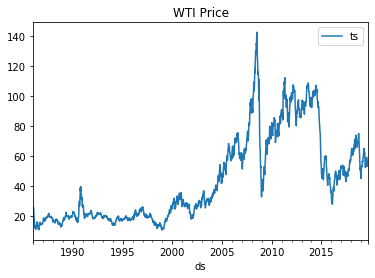

In [186]:
# Plot time series data
df.plot()
plt.title('WTI Price')
plt.show()

Next step is to check if the data is stationary. Augmented Dickey-Fuller unit root test helps to findout that.

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
* http://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html

In [187]:
from statsmodels.tsa.stattools import adfuller # importing a package

# preparing a fucntion to be able to call DFuller test on every transformation

def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

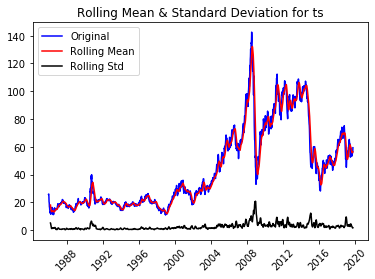

Results of Dickey-Fuller Test:
Test Statistic                   -2.399473
p-value                           0.141885
# Lags Used                       8.000000
Number of Observations Used    1751.000000
Critical Value (1%)              -3.434090
Critical Value (5%)              -2.863192
Critical Value (10%)             -2.567649
dtype: float64


In [188]:
test_stationarity(df = df, ts = 'ts')

p-value is 0.141885 which means I failed to reject the H0.

# Stationarizing the Data #

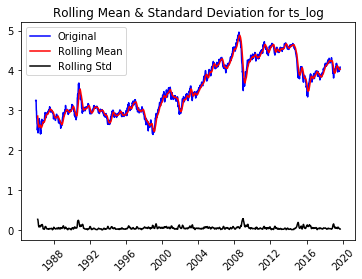

Results of Dickey-Fuller Test:
Test Statistic                   -1.935175
p-value                           0.315699
# Lags Used                       8.000000
Number of Observations Used    1751.000000
Critical Value (1%)              -3.434090
Critical Value (5%)              -2.863192
Critical Value (10%)             -2.567649
dtype: float64


In [189]:
# log tranformation
df['ts_log']=df['ts'].apply(lambda x: np.log(x))
test_stationarity(df=df,ts='ts_log')

p-value is still high, it should be lesss than 0.05

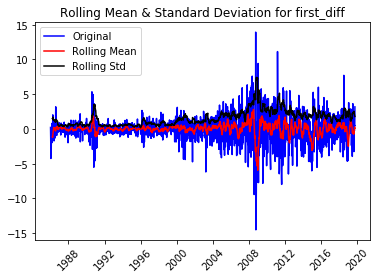

Results of Dickey-Fuller Test:
Test Statistic                -9.489856e+00
p-value                        3.677559e-16
# Lags Used                    1.900000e+01
Number of Observations Used    1.739000e+03
Critical Value (1%)           -3.434116e+00
Critical Value (5%)           -2.863203e+00
Critical Value (10%)          -2.567656e+00
dtype: float64


In [190]:
# taking the first difference
df['first_diff'] = df['ts'] - df['ts'].shift(1)
test_stationarity(df=df.dropna(inplace=False),ts='first_diff')

**Now p-value is lower than 0.05 which means our data is stationarized.**

In [191]:
# transformation:  7-day MA of ts and log_ts
df['ts_log_ma']=df['ts_log'].rolling(window=7, center=False).mean()
df['ts_ma']=df['ts'].rolling(window=7, center=False).mean()

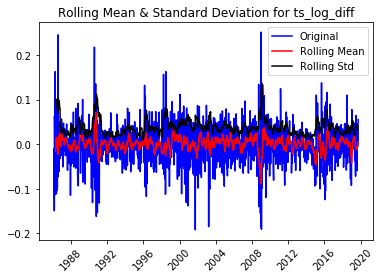

Results of Dickey-Fuller Test:
Test Statistic                -1.234434e+01
p-value                        6.019596e-23
# Lags Used                    1.000000e+01
Number of Observations Used    1.743000e+03
Critical Value (1%)           -3.434107e+00
Critical Value (5%)           -2.863200e+00
Critical Value (10%)          -2.567654e+00
dtype: float64


In [192]:
# transformation: first diff of ts_log
df['ts_log_diff']=df['ts_log'].diff()
test_stationarity(df=df.dropna(inplace=False),ts='ts_log_diff')

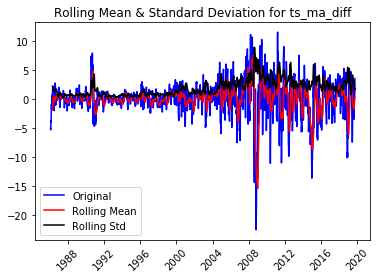

Results of Dickey-Fuller Test:
Test Statistic                -9.520526e+00
p-value                        3.073618e-16
# Lags Used                    1.800000e+01
Number of Observations Used    1.735000e+03
Critical Value (1%)           -3.434125e+00
Critical Value (5%)           -2.863207e+00
Critical Value (10%)          -2.567658e+00
dtype: float64


In [193]:
# transformation: diff ts and ts_ma
df['ts_ma_diff']=df['ts']-df['ts_ma']
test_stationarity(df=df.dropna(inplace=False),ts='ts_ma_diff')

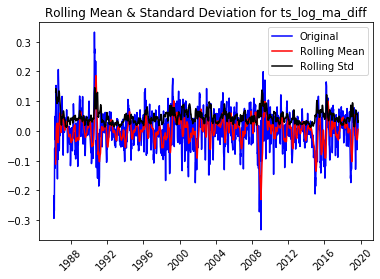

Results of Dickey-Fuller Test:
Test Statistic                -1.028283e+01
p-value                        3.740773e-18
# Lags Used                    1.400000e+01
Number of Observations Used    1.739000e+03
Critical Value (1%)           -3.434116e+00
Critical Value (5%)           -2.863203e+00
Critical Value (10%)          -2.567656e+00
dtype: float64


In [194]:
# transformation: diff ts_log, ts_log_ma
df['ts_log_ma_diff']=df['ts_log']-df['ts_log_ma']
test_stationarity(df=df.dropna(inplace=False),ts='ts_log_ma_diff')

In [195]:
# transformation: diff ts_log, ts_log_ma
df_new = df.dropna()

In [197]:
df_new.head(3)

,ts,ts_log,first_diff,ts_log_ma,ts_ma,ts_log_diff,ts_ma_diff,ts_log_ma_diff
ds,,,,,,,,
1986-02-14,16.25,2.788093,-0.47,3.043537,21.330000,-0.028513,-5.080000,-0.255444
1986-02-21,14.39,2.666534,-1.86,2.960242,19.702857,-0.121559,-5.312857,-0.293709
1986-02-28,14.25,2.656757,-0.14,2.874391,18.025714,-0.009777,-3.775714,-0.217634


In [198]:
df_new.index = pd.to_datetime(df_new.index)

In [199]:
# transformation: ts_log to logged exponentially weighted MA
df_new['ts_log_ewma']=df_new['ts_log'].ewm(halflife=7,ignore_na=False,min_periods=0,adjust=True).mean()

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


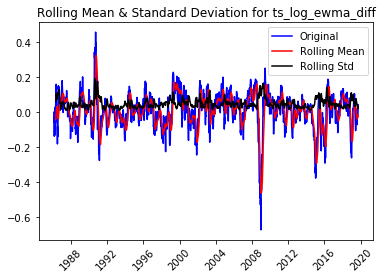

Results of Dickey-Fuller Test:
Test Statistic                -8.796290e+00
p-value                        2.171944e-14
# Lags Used                    1.400000e+01
Number of Observations Used    1.739000e+03
Critical Value (1%)           -3.434116e+00
Critical Value (5%)           -2.863203e+00
Critical Value (10%)          -2.567656e+00
dtype: float64


In [200]:
# transformation: diff ts_log, ts-log_ewma
df_new['ts_log_ewma_diff']=df_new['ts_log']-df_new['ts_log_ewma']
test_stationarity(df=df_new.dropna(inplace=False),ts='ts_log_ewma_diff')

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


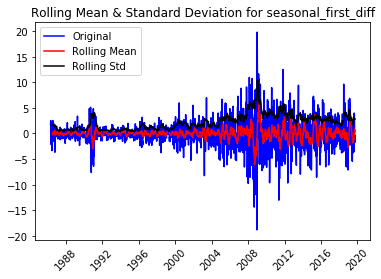

Results of Dickey-Fuller Test:
Test Statistic                -1.269297e+01
p-value                        1.121728e-23
# Lags Used                    2.500000e+01
Number of Observations Used    1.716000e+03
Critical Value (1%)           -3.434166e+00
Critical Value (5%)           -2.863226e+00
Critical Value (10%)          -2.567667e+00
dtype: float64


In [201]:
df_new['seasonal_first_diff'] = df_new.first_diff - df_new.first_diff.shift(12)  
test_stationarity(df=df_new.dropna(inplace=False), ts='seasonal_first_diff')

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/indexing.py:562: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<Figure size 432x288 with 0 Axes>

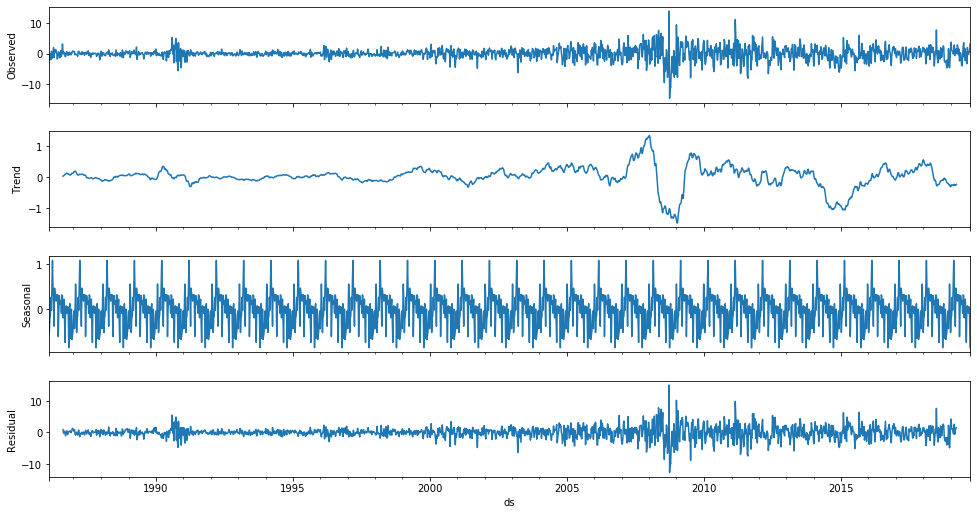

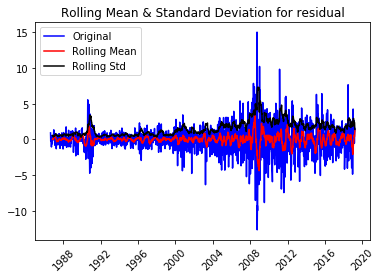

Results of Dickey-Fuller Test:
Test Statistic                -1.276893e+01
p-value                        7.847123e-24
# Lags Used                    2.400000e+01
Number of Observations Used    1.677000e+03
Critical Value (1%)           -3.434255e+00
Critical Value (5%)           -2.863265e+00
Critical Value (10%)          -2.567688e+00
dtype: float64


In [202]:
# decomposing data into trend, noise and seasonality

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_new['first_diff'], freq=52)

df_new.loc[:,'trend'] = decomposition.trend
df_new.loc[:,'seasonal'] = decomposition.seasonal
df_new.loc[:,'residual'] = decomposition.resid

fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

test_stationarity(df = df_new.dropna(), ts = 'residual')

## ACF & PACF ##

**ARIMA = Auto-Regressive Integrated Moving Average**.  

**Assumptions.** The time-series is stationary.  
**Depends on:**  
  **1. Number of AR (Auto-Regressive) terms (p).**  
  **2. Number of I (Integrated or Difference) terms (d).**  
  **3. Number of MA (Moving Average) terms (q).**  


**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots (below).

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


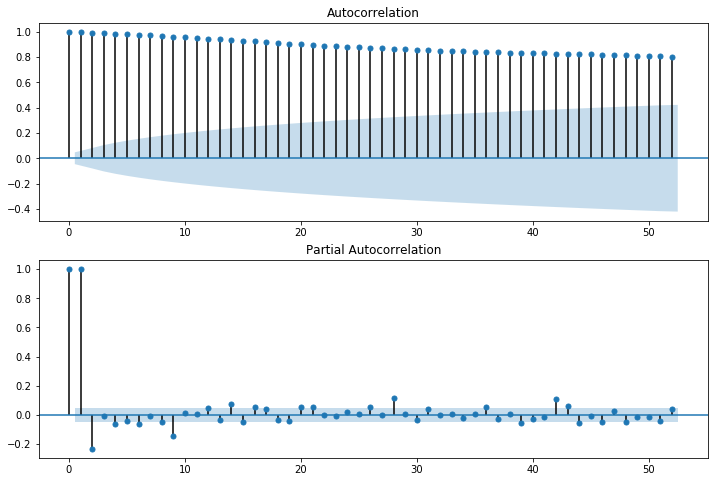

In [203]:
# original data
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df.ts.iloc[1:], lags=52,ax=ax1)
ax2 = fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df.ts.iloc[1:], lags=52,ax=ax2)

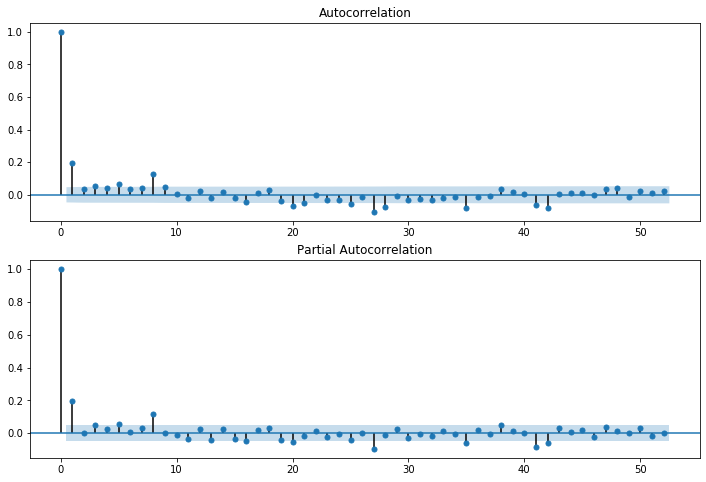

In [204]:
# first diff
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(df_new.first_diff.iloc[1:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(df_new.first_diff.iloc[1:], lags=52, ax=ax2)

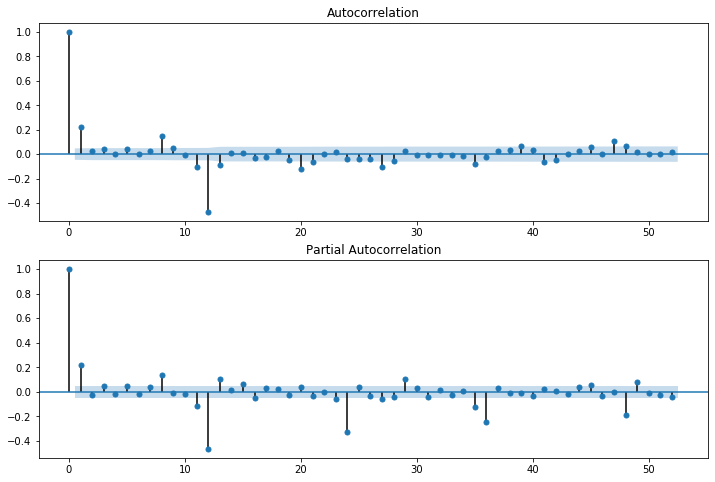

In [205]:
# seasonal diff
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(df_new.seasonal_first_diff.iloc[13:], lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(df_new.seasonal_first_diff.iloc[13:], lags=52, ax=ax2)

In [265]:
df_new['ts'][1750:]

ds
2019-08-30    55.21
2019-09-06    55.73
2019-09-13    56.16
2019-09-20    59.33
Name: ts, dtype: float64

In [2]:
# saving transformed data as modelling data
# df_new.to_csv('data/modelling_data.csv')

**Summary**
_______

* Our data is stationarized using first level differencing, (d = 1)
* ACF & PACF plots indicate that our model needs 1 AR, and 0 MA, (p=1,q=0)
* SARIMA model is going to be used becuase our data has seasonality

## Modelling##

In [2]:
df = pd.read_csv('data/modelling_data.csv', index_col=0)

In [3]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['1986-02-14', '1986-02-21', '1986-02-28', '1986-03-07',
               '1986-03-14', '1986-03-21', '1986-03-28', '1986-04-04',
               '1986-04-11', '1986-04-18',
               ...
               '2019-07-19', '2019-07-26', '2019-08-02', '2019-08-09',
               '2019-08-16', '2019-08-23', '2019-08-30', '2019-09-06',
               '2019-09-13', '2019-09-20'],
              dtype='datetime64[ns]', name='ds', length=1754, freq=None)

**Modelling**

In [5]:
# fit sarima model
model = sm.tsa.statespace.SARIMAX(df['ts'][0:1600],trend='n', order=(1,1,0), seasonal_order=(0,1,1,52))
res = model.fit()

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


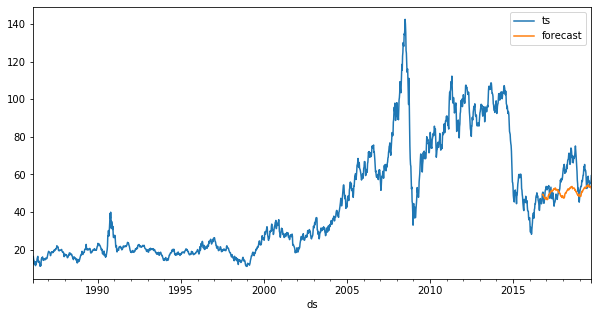

In [6]:
# forecast
df['forecast'] = res.predict(start = 1600, end= 1754, dynamic=False)  
df[['ts', 'forecast']].plot(figsize=(10, 5)) 

In [8]:
npredict =df.ts['2017'].shape[0]
nobs = df.ts.shape[0]

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/indexing.py:947: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-

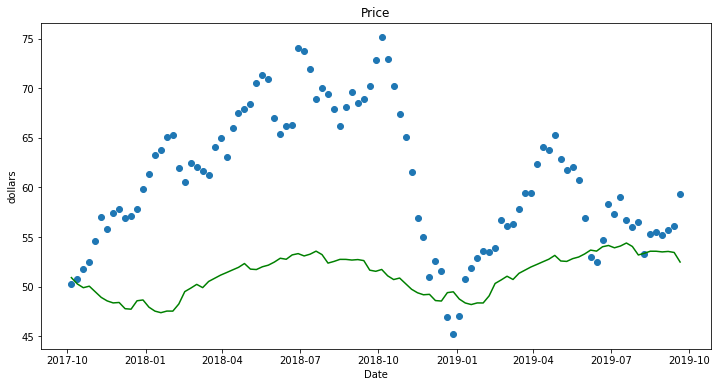

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
npre = 52
ax.set(title='Price', xlabel='Date', ylabel='dollars')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'ts'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Forecast')
# plt.savefig('trained_vs_actual.png', bbox_inches='tight')

In [15]:
# re-trainging the model, fitting to the whole data
model = sm.tsa.statespace.SARIMAX(df['ts'],trend='n', order=(1,1,0), seasonal_order=(0,1,1,52))
res = model.fit()

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


## Forecasting 2019-2025##

In [16]:
# predicting 2019-2025
# creating future date time series

from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2019-09-20", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,260)]
future = pd.DataFrame(index=date_list, columns= df.columns)
pred = pd.concat([df, future])

**2019-2025 Prediction**

In [17]:
# prediction, dynamic=False
# creating new forecast column in our dataset
pred['forecast'] = res.predict(start = 1754, end=2014, dynamic=False)  

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


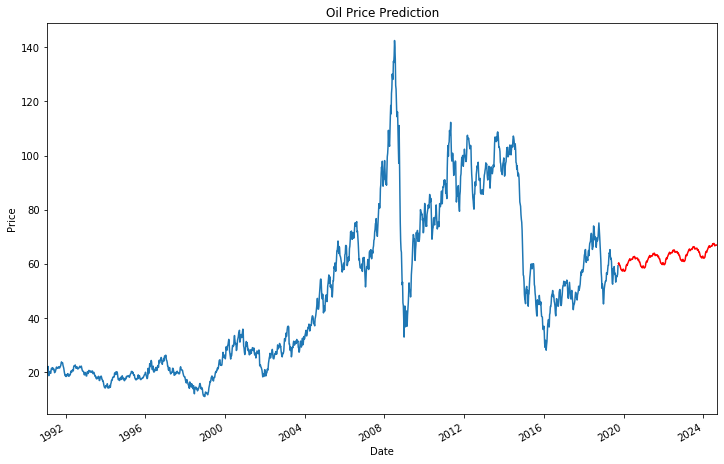

In [18]:
# plotting the prediction
ax1 = pred['ts'].ix[-1755:].plot(figsize=(12, 8))
ax2 = pred['forecast'].ix[-1755:].plot(color='red')
ax1.set(title='Oil Price Prediction', xlabel='Date', ylabel='Price')
# plt.savefig('ts_predict_future.png', bbox_inches='tight')
plt.show()

In [13]:
# prediction, dynamic =True
# creating forecast_dynamic column in our dataset
pred['forecast_dynamic'] = res.predict(start = 1754, end=2014, dynamic=False)  

/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


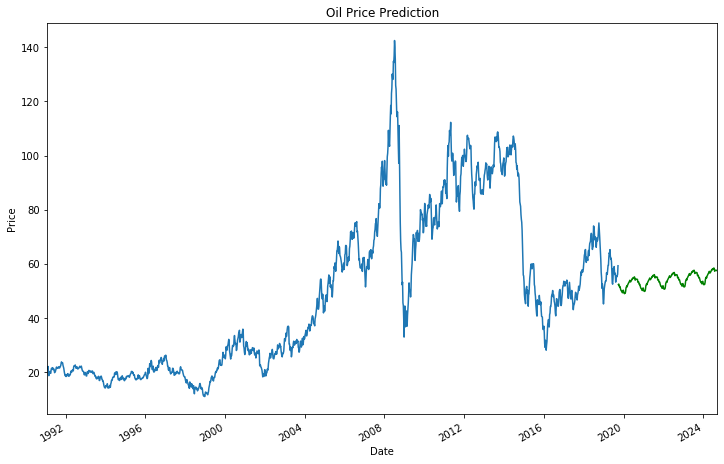

In [14]:
# plotting predicted values, dynamic = True
ax3 = pred['ts'].ix[-1755:].plot(figsize=(12, 8))
ax4 = pred['forecast_dynamic'].ix[-1755:].plot(color='green')
ax3.set(title='Oil Price Prediction',xlabel='Date',ylabel='Price')
plt.show()
# plt.savefig('ts_predict_future.png', bbox_inches='tight')